In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import time
import os
from typing import Dict, List, Tuple
from tensorflow.keras import layers, models
from typing import List, Dict, Tuple, Optional


In [3]:
df = pd.read_csv("/Users/sohinikar/M.Tech_Dissertation/Obfuscated-MalMem2022.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


In [4]:
df.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
count,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,5.859600e+04,58596.000000,58596.0,...,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,58596.000000
mean,41.394771,14.713837,11.341655,0.0,247.509819,1810.805447,43.707806,1.025858e+04,249.560958,0.0,...,391.347549,221.406581,25.996245,25.063417,116.879514,0.0,121.995546,86.905659,0.000853,7.999881
std,5.777249,2.656748,1.588231,0.0,111.857790,329.782639,5.742023,4.866864e+03,145.999866,0.0,...,4.529704,1.991087,0.170790,1.529628,1.550401,0.0,2.822858,3.134117,0.029199,0.010929
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,94.000000,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000
25%,40.000000,12.000000,9.972973,0.0,208.725000,1556.000000,38.833333,8.393000e+03,209.648228,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000
50%,41.000000,15.000000,11.000000,0.0,243.963710,1735.000000,42.781524,9.287500e+03,247.208951,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000
75%,43.000000,16.000000,12.861955,0.0,289.974322,2087.000000,49.605280,1.219300e+04,291.355050,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000


In [5]:
df.shape

(58596, 57)

# Data Cleaning

In [6]:
# checking all the values in the columns are indetical
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"All values in {column} are identical.")

All values in pslist.nprocs64bit are identical.
All values in handles.nport are identical.
All values in svcscan.interactive_process_services are identical.


In [7]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [8]:
#checking for columns with null values

null_columns = df.columns[df.isnull().any()]
print("Columns with nulls:", list(null_columns))

Columns with nulls: []


# Encoding

In [9]:
df['Class'] = df['Class'].map({'Benign': 0, 'Malware': 1}) if df['Class'].dtype == 'object' else df['Class']

# sanity check of data before splitting

In [10]:
print("\nData Info:")
print(df.info())
print("\nFirst Few Rows:")
print(df.head())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.avg_handlers                     58596 non-null  float64
 5   dlllist.ndlls                           58596 non-null  int64  
 6   dlllist.avg_dlls_per_proc               58596 non-null  float64
 7   handles.nhandles                        58596 non-null  int64  
 8   handles.avg_handles_per_proc            58596 non-null  float64
 9   handles.nfile                           58596 non-null  int64  
 10  handles.nevent                          58596 

In [11]:
print("DataFrame Shape:", df.shape)
print("Class Distribution:", df["Class"].value_counts())

DataFrame Shape: (58596, 54)
Class Distribution: Class
0    29298
1    29298
Name: count, dtype: int64


In [12]:
X = df.drop(columns=['Class','Category'])
y = df["Class"]

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Steep rise initially:
The first ~10 components capture a large portion of the total variance — roughly 90–95%.
This means most of the useful information is concentrated in those first few components.

Elbow point (approx at component 10–15):
After ~15 components, the curve flattens — additional components add very little new information (variance).

Plateau near 1.0:
Around 20–25 components, you reach nearly 100% variance retained, so including more components beyond that is redundant.

# Splitting the data

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=7)

# Feedforward Neural Network for Binary Classification (FNN-BC)

In [15]:
early_stop = EarlyStopping(
    monitor="accuracy",      # or "val_accuracy"
    mode="max",
    patience=0,              # stop as soon as it stops improving
    min_delta=0.0,           # minimum change
    verbose=1
)

In [16]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(52,)),  # 52 input features
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 1
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),  # hidden layer 2
    tf.keras.layers.Dropout(0.5),  # dropout to avoid overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')  # output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # optimizer
    loss='binary_crossentropy',            # binary classification loss
    metrics=['accuracy', tf.keras.metrics.Recall()]  # metrics
)

# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 10)             │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
full_start = time.time()
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=30,
          batch_size=64,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")

Epoch 1/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - accuracy: 0.6583 - loss: 0.7291 - recall: 0.5265 - val_accuracy: 0.9900 - val_loss: 0.1728 - val_recall: 0.9911
Epoch 2/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.9277 - loss: 0.2751 - recall: 0.9747 - val_accuracy: 0.9931 - val_loss: 0.0387 - val_recall: 0.9930
Epoch 3/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.9464 - loss: 0.1904 - recall: 0.9853 - val_accuracy: 0.9948 - val_loss: 0.0191 - val_recall: 0.9955
Epoch 4/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.9527 - loss: 0.1565 - recall: 0.9913 - val_accuracy: 0.9975 - val_loss: 0.0122 - val_recall: 0.9976
Epoch 5/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.9630 - loss: 0.1561 - recall: 0.9943 - val_accuracy: 0.9973 - val_loss: 0.0093 - val_recall: 0.9981
Epoch 6/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.9719 - loss: 0.1133 - recall: 0.9957 - val_accuracy: 0.9974 - val_loss: 0.0087 - val_recall:

## LSTM-BC: Long Short-Term Memory for Binary Classification

In [18]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])).astype(np.float32)
X_test_lstm  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1])).astype(np.float32)

In [19]:
y_train = np.asarray(y_train).astype(np.float32)
y_test  = np.asarray(y_test).astype(np.float32)

In [20]:
lstm_bc = tf.keras.Sequential([
    tf.keras.Input(shape=(1, 52)),                # (timesteps, 52 features)
    tf.keras.layers.LSTM(13, activation='relu'),     # outputs 13-d vector
    tf.keras.layers.Dense(1, activation='sigmoid')   # binary output
])

lstm_bc.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name="recall")]
)

lstm_bc.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13)             │         3,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,446 (13.46 KB)

 Trainable params: 3,446 (13.46 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
full_start = time.time()
lstm_bc.fit(X_train_lstm, y_train,
          validation_data=(X_test_lstm, y_test),
          epochs=30,
          batch_size=64,
          verbose=1,
          callbacks=[early_stop]
)
full_end = time.time()
print(f"Training time = {full_end - full_start:.3f} seconds")


Epoch 1/30


641/641 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.8639 - loss: 0.3408 - recall: 0.8202 - val_accuracy: 0.9954 - val_loss: 0.0198 - val_recall: 0.9952
Epoch 2/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.9965 - loss: 0.0159 - recall: 0.9963 - val_accuracy: 0.9974 - val_loss: 0.0086 - val_recall: 0.9967
Epoch 3/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.9984 - loss: 0.0076 - recall: 0.9979 - val_accuracy: 0.9981 - val_loss: 0.0057 - val_recall: 0.9975
Epoch 4/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.9987 - loss: 0.0049 - recall: 0.9981 - val_accuracy: 0.9986 - val_loss: 0.0045 - val_recall: 0.9985
Epoch 5/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.9989 - loss: 0.0044 - recall: 0.9985 - val_accuracy: 0.9987 - val_loss: 0.0038 - val_recall: 0.9989
Epoch 6/30
641/641 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.9991 - loss: 0.0038 - recall: 0.9988 - val_accuracy: 0.9987 - val_loss: 0.0033 - val_recall: 0.9990
Epo

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.9982 - loss: 0.0076 - recall: 0.9988 
Test Loss: 0.0070
Test Accuracy: 0.9981
Test precision: 0.9986
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8767
         1.0       1.00      1.00      1.00      8812

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



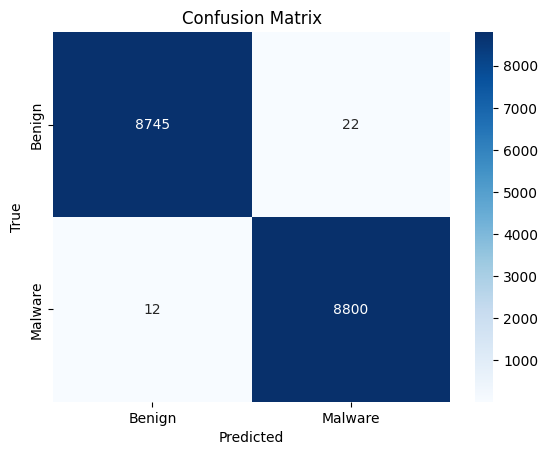

In [22]:
loss, acc , precision= model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.9996 - loss: 0.0013 - recall: 1.0000 
Test Loss: 0.0012
Test Accuracy: 0.9995
Test precision: 1.0000
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8767
         1.0       1.00      1.00      1.00      8812

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



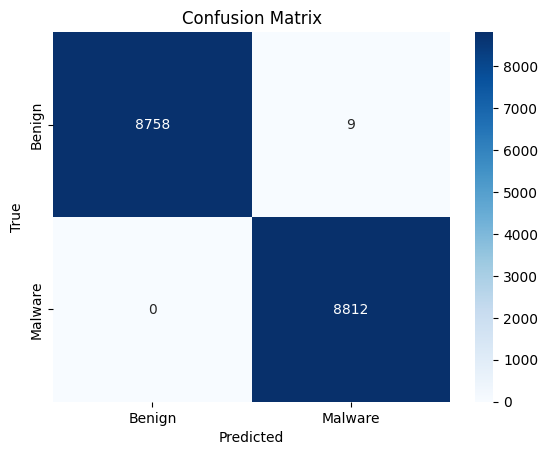

In [23]:
loss, acc , precision= lstm_bc.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Test precision: {precision:.4f}")

# Classification Report
y_pred = (lstm_bc.predict(X_test_lstm) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malware"], yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Federated learning

## Helpers

In [24]:
def clone_optimizer_from_global_model(global_model: tf.keras.Model):
    try:
        opt = global_model.optimizer
        if opt is None:
            return tf.keras.optimizers.Adam()
        return opt.__class__.from_config(opt.get_config())
    except Exception:
        return tf.keras.optimizers.Adam()

In [25]:
def federated_average_scaled_weights(scaled_weight_list: List[List[np.ndarray]], total_size: int) -> List[np.ndarray]:
    total = [np.zeros_like(w) for w in scaled_weight_list[0]]
    for sw in scaled_weight_list:
        for i, w in enumerate(sw):
            total[i] += w
    return [w / max(total_size, 1) for w in total]


In [26]:
def summarize_weights_detailed(weights: List[np.ndarray], values_per_layer: int = 5):
    details = []
    for w in weights:
        flat = w.ravel()
        details.append({
            "shape": tuple(w.shape),
            "l2": float(np.linalg.norm(w)),
            "mean": float(flat.mean()) if flat.size else 0.0,
            "std": float(flat.std()) if flat.size else 0.0,
            "min": float(flat.min()) if flat.size else 0.0,
            "max": float(flat.max()) if flat.size else 0.0,
            "sample_values": flat[:values_per_layer].astype(float).tolist()
        })
    return details

In [27]:
def print_parameter_block(client_id: str, details, scale_factor: float, limit_layers: int = 4):
    print("=== Parameters sent to GLOBAL (sample client) ===")
    print(f"{client_id}: first {min(limit_layers, len(details))} layers (shape, L2, mean, std, min, max, first few vals)")
    for d in details[:limit_layers]:
        shp = d["shape"]; l2 = d["l2"]
        mean, std, vmin, vmax = d["mean"], d["std"], d["min"], d["max"]
        vals = ", ".join(f"{v:.4f}" for v in d["sample_values"])
        print(f"  {shp}  L2={l2:.4f}  mean={mean:.4f}  std={std:.4f}  min={vmin:.4f}  max={vmax:.4f}")
        print(f"    values: [{vals}]")
    print(f"Scale factor (client_size/total_size): {scale_factor:.6f}")
    print("===============================================\n")

In [28]:
import numpy as np
from typing import Dict

def assign_fixed_clients_from_test(
    X: np.ndarray,
    y: np.ndarray,
    num_clients: int,
    base_total: int,
    base_clients: int,
    seed: int = 0,
    wrap: bool = True,
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Create a fixed client assignment with equal per-client size = base_total // base_clients.
    If wrap=True and X/y are shorter than base_total, indices repeat cyclically to fill.
    """
    X = np.asarray(X)
    y = np.asarray(y)
    assert y.ndim == 1, "y must be 1-D (binary labels)."
    assert len(X) == len(y), "X and y must have the same length."
    assert base_clients > 0 and base_total > 0, "base_total/base_clients must be > 0."
    assert base_total % base_clients == 0, "base_total must be divisible by base_clients."
    assert num_clients == base_clients, "num_clients must equal base_clients for fixed sizing."

    per_user = base_total // base_clients
    n = len(X)

    rng = np.random.default_rng(seed)
    # Shuffle the base index order once for reproducibility
    base_order = rng.permutation(n)

    # Build exactly base_total indices (with wrap if needed)
    if base_total <= n:
        idx = base_order[:base_total]
    else:
        if not wrap:
            raise ValueError(
                f"Need {base_total} samples but dataset has only {n}. "
                "Set wrap=True to repeat indices."
            )
        times = base_total // n
        rem = base_total % n
        idx = np.concatenate([np.tile(base_order, times), base_order[:rem]])

    # Slice into contiguous per-client chunks
    assignment = {}
    start = 0
    for c in range(num_clients):
        end = start + per_user
        take = idx[start:end]
        assignment[f"client_{c+1}"] = {
            "X": X[take],
            "y": y[take],
        }
        start = end

    # Quick sanity check
    assert start == base_total, "Internal error: did not distribute expected total samples."
    return assignment


In [29]:
# ---------- metrics & eval ----------
def binary_metrics(y_true: np.ndarray, y_prob: np.ndarray, thr: float = 0.5):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_prob = np.asarray(y_prob).ravel()
    eps = 1e-12
    y_prob = np.clip(y_prob, eps, 1 - eps)  # avoid log(0) runtime warning
    y_hat = (y_prob >= thr).astype(int)

    tp = int(((y_true == 1) & (y_hat == 1)).sum())
    tn = int(((y_true == 0) & (y_hat == 0)).sum())
    fp = int(((y_true == 0) & (y_hat == 1)).sum())
    fn = int(((y_true == 1) & (y_hat == 0)).sum())

    acc = (tp + tn) / max(len(y_true), 1)
    prec = tp / max(tp + fp, 1)
    rec = tp / max(tp + fn, 1)
    f1 = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec)

    bce = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
    return {"loss": float(bce), "accuracy": float(acc), "precision": float(prec), "recall": float(rec), "f1": float(f1)}

def evaluate_global_model_binary(model: tf.keras.Model, X_eval: np.ndarray, y_eval: np.ndarray, model_kind: str):
    X_eval = np.asarray(X_eval); y_eval = np.asarray(y_eval).ravel()
    if model_kind.lower() == "lstm":
        X_eval_in = np.expand_dims(X_eval, 1)  # (N,F) -> (N,1,F)
    else:
        X_eval_in = X_eval
    y_prob = model.predict(X_eval_in, verbose=0)
    return binary_metrics(y_eval, y_prob)

In [30]:
from typing import Dict, Tuple, Optional, Any
import numpy as np
import tensorflow as tf
from copy import deepcopy

def _ensure_numpy(x):
    return x if isinstance(x, np.ndarray) else np.asarray(x)

def _clone_model_with_weights(model: tf.keras.Model) -> tf.keras.Model:
    clone = tf.keras.models.clone_model(model)
    clone.set_weights(model.get_weights())

    if not hasattr(model, "optimizer") or model.optimizer is None:
        raise ValueError("Global model must be compiled before FL.")

    # Detach optimizer state cleanly
    opt = tf.keras.optimizers.deserialize(
        tf.keras.optimizers.serialize(model.optimizer)
    )

    # Compile WITHOUT metrics to avoid Mean/Sum (and wrappers) signature issues
    clone.compile(optimizer=opt, loss=model.loss, metrics=[])
    return clone

def _count_trainable_params(model: tf.keras.Model) -> int:
    return int(np.sum([np.prod(w.shape) for w in model.trainable_weights]))

def _layer_value_preview(model: tf.keras.Model, values_per_layer: int = 5) -> Dict[str, Any]:
    """
    Return a small preview of the first few values from each trainable weight tensor.
    """
    preview = {}
    for w in model.trainable_weights:
        name = w.name
        arr = w.numpy().ravel()
        preview[name] = arr[:min(values_per_layer, arr.size)].tolist()
    return preview

def _weighted_fedavg(weights_list, sizes):
    """
    weights_list: list of lists of numpy arrays (one list per client = model weights)
    sizes: list of ints (number of samples per client)
    returns: list of numpy arrays (averaged weights)
    """
    total = float(np.sum(sizes))
    # Initialize accumulator with zeros like the first client’s weights
    agg = [np.zeros_like(w) for w in weights_list[0]]
    for client_w, n in zip(weights_list, sizes):
        coef = n / total if total > 0 else 0.0
        for i, w in enumerate(client_w):
            agg[i] = agg[i] + coef * w
    return agg

def _split_evenly(X, y, users: int) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Fallback splitter if client_assignment is not provided: even contiguous splits.
    """
    X = _ensure_numpy(X)
    y = _ensure_numpy(y)
    n = len(X)
    idxs = np.arange(n)
    np.random.shuffle(idxs)
    parts = np.array_split(idxs, users)
    out = {}
    for i, p in enumerate(parts):
        out[f"client_{i+1}"] = {"X": X[p], "y": y[p]}
    return out

def run_federated_round(
    global_model: tf.keras.Model,
    X,
    y,
    model_kind,            # "fnn" or "lstm" (fnn path here is straightforward)
    users: int = 5,
    batch_size: int = 128,
    local_epochs: int = 1,
    rounds: int = 1,
    verbose: int = 1,
    log_params: bool = True,
    show_parameter_numbers: bool = True,
    values_per_layer: int = 5,
    eval_data: Optional[Tuple[np.ndarray, np.ndarray]] = None,
    client_assignment: Optional[Dict[str, Dict[str, np.ndarray]]] = None,
) -> Dict:
    """
    Simulates Federated Averaging (FedAvg) with optional fixed client_assignment.
    Assumes `global_model` is already compiled.
    """

    if model_kind.lower() not in {"fnn", "lstm"}:
        raise ValueError("model_kind must be 'fnn' or 'lstm'.")

    # Prepare clients
    if client_assignment is None:
        clients = _split_evenly(X, y, users)
    else:
        # Normalize incoming dict and ensure numpy
        clients = {}
        for cid, d in client_assignment.items():
            Xi = _ensure_numpy(d["X"])
            yi = _ensure_numpy(d["y"])
            clients[cid] = {"X": Xi, "y": yi}

    # Reporting scaffolding
    report = {
        "rounds": rounds,
        "clients": list(clients.keys()),
        "samples_per_client": {cid: int(len(d["X"])) for cid, d in clients.items()},
        "per_round": [],          # list of dicts with metrics
        "final_eval": None,       # evaluation on eval_data after last round
        "model_kind": model_kind,
        "trainable_params": None,
        "param_preview": None,
    }

    if show_parameter_numbers:
        report["trainable_params"] = _count_trainable_params(global_model)

    if log_params:
        report["param_preview"] = _layer_value_preview(global_model, values_per_layer)

    if verbose:
        print(f"[FL] Starting simulation: {rounds} rounds, {len(clients)} clients")
        print(f"[FL] Samples per client: {report['samples_per_client']}")
        if show_parameter_numbers:
            print(f"[FL] Trainable parameters: {report['trainable_params']}")

    # FL rounds
    for r in range(1, rounds + 1):
        if verbose:
            print(f"\n[FL] ----- Round {r}/{rounds} -----")

        # Broadcast current global weights
        global_weights = [w.copy() for w in global_model.get_weights()]

        # Local training on each client
        client_weights = []
        client_sizes = []
        local_histories = {}

        for cid, data in clients.items():
            Xi, yi = data["X"], data["y"]

            # Model clone with current global weights & same compile config
            local_model = _clone_model_with_weights(global_model)
            local_model.set_weights(global_weights)

            # Optional: shape handling for LSTM (expects [N, timesteps, features])
            if model_kind.lower() == "lstm":
                if Xi.ndim == 2:
                    # Heuristic: treat features as time steps of length 1
                    Xi_local = Xi[:, :, None]
                else:
                    Xi_local = Xi
            else:
                Xi_local = Xi

            hist = local_model.fit(
                Xi_local, yi,
                batch_size=batch_size,
                epochs=local_epochs,
                verbose=0,
                shuffle=True,
            )

            local_histories[cid] = {
                "loss": [float(x) for x in hist.history.get("loss", [])],
            }

            client_weights.append([w.copy() for w in local_model.get_weights()])
            client_sizes.append(int(len(Xi)))

        # Federated averaging
        new_global = _weighted_fedavg(client_weights, client_sizes)
        global_model.set_weights(new_global)

        # Evaluate on eval_data (if provided)
        eval_metrics = None
        if eval_data is not None:
            Xte, yte = eval_data
            Xte = _ensure_numpy(Xte)
            yte = _ensure_numpy(yte)
            if model_kind.lower() == "lstm" and Xte.ndim == 2:
                Xte_eval = Xte[:, :, None]
            else:
                Xte_eval = Xte
            eval_vals = global_model.evaluate(Xte_eval, yte, verbose=0)
            # Keras returns [loss, metric1, metric2, ...]; collect names
            names = ["loss"] + [m.name if hasattr(m, "name") else str(m) for m in global_model.metrics]
            eval_metrics = {names[i]: float(eval_vals[i]) for i in range(len(eval_vals))}

        # Optional logging of parameter preview after each round
        params_preview = _layer_value_preview(global_model, values_per_layer) if log_params else None
        trainable_params_now = _count_trainable_params(global_model) if show_parameter_numbers else None

        per_round_entry = {
            "round": r,
            "local_histories": local_histories,  # per-client local training loss(es)
            "eval": eval_metrics,               # global eval after aggregation
            "trainable_params": trainable_params_now,
            "param_preview": params_preview,
            "client_sizes": {c: s for c, s in zip(clients.keys(), client_sizes)},
        }
        report["per_round"].append(per_round_entry)

        if verbose and eval_metrics is not None:
            metrics_str = ", ".join([f"{k}: {v:.4f}" for k, v in eval_metrics.items()])
            print(f"[FL] Global eval -> {metrics_str}")

    # Final evaluation snapshot (duplicate of last per-round eval for convenience)
    if eval_data is not None and len(report["per_round"]) > 0:
        report["final_eval"] = deepcopy(report["per_round"][-1]["eval"])

    return report


In [31]:
per_user = 5888 // 128  # 46
users = 8 
assignment = assign_fixed_clients_from_test(
    X_test, y_test,
    num_clients=users,
    base_total=5888, base_clients=128,  # keeps per_user = 46
    seed=7, wrap=True                   # wrap=True repeats test samples if needed
)

AssertionError: num_clients must equal base_clients for fixed sizing.

In [ ]:
# Run one FL round:
report_fnn = run_federated_round(
    global_model=model,          # your compiled FNN (52 -> ... -> 1)
    X=X_test, y=y_test,        # not used for splitting when client_assignment is provided
    model_kind="fnn",
    users=8,
    batch_size=128,
    local_epochs=1,
    rounds=5,
    eval_data=(X_test, y_test),  # evaluate on test
    client_assignment=assignment, # <— fixed 46-sample chunks per client
    log_params=True, show_parameter_numbers=True, values_per_layer=5,
)

# (optional) plot
#plot_fl_report(report_fnn, show_loss=True, save_prefix=None)


[FL] Starting simulation: 5 rounds, 8 clients
[FL] Samples per client: {'client_1': 46, 'client_2': 46, 'client_3': 46, 'client_4': 46, 'client_5': 46, 'client_6': 46, 'client_7': 46, 'client_8': 46}
[FL] Trainable parameters: 651

[FL] ----- Round 1/5 -----
[FL] Global eval -> loss: 0.9984, compile_metrics: 0.9992

[FL] ----- Round 2/5 -----
[FL] Global eval -> loss: 0.9984, compile_metrics: 0.9992

[FL] ----- Round 3/5 -----
[FL] Global eval -> loss: 0.9984, compile_metrics: 0.9992

[FL] ----- Round 4/5 -----
[FL] Global eval -> loss: 0.9984, compile_metrics: 0.9992

[FL] ----- Round 5/5 -----
[FL] Global eval -> loss: 0.9984, compile_metrics: 0.9992


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fl_report(report, show_loss=True, save_prefix=None):
    """
    Plot metrics from the FL 'report' dict returned by run_federated_round(...).

    Expected structure (from our helper):
      report["per_round"][i]["eval"]             -> dict of eval metrics after round i+1
      report["per_round"][i]["client_sizes"]     -> {client_id: n_samples} for round i+1
      report["samples_per_client"]               -> global mapping {client_id: n_samples} (optional)

    Plots (shown only if data exists):
      - Accuracy vs Rounds
      - F1 vs Rounds
      - (optional) Loss vs Rounds
      - Client sizes (bar chart for last round)
    """
    per_round = report.get("per_round", [])
    if not per_round:
        raise ValueError("report['per_round'] is empty. Did training run with rounds>=1?")

    # Collect eval metrics per round
    rounds = np.arange(1, len(per_round) + 1, dtype=int)
    acc_list, f1_list, loss_list = [], [], []

    # Helper to fetch a metric from a dict with flexible names (case-insensitive)
    def get_metric(d, *names):
        if not d:
            return None
        lower = {k.lower(): v for k, v in d.items()}
        for name in names:
            if name in lower:
                return lower[name]
        return None

    for entry in per_round:
        evald = entry.get("eval", {})
        acc_list.append(get_metric(evald, "accuracy", "acc"))
        f1_list.append(get_metric(evald, "f1", "f1_score"))
        loss_list.append(get_metric(evald, "loss"))

    # Convert to numpy, marking missing as NaN
    acc = np.array([np.nan if v is None else float(v) for v in acc_list], dtype=float)
    f1  = np.array([np.nan if v is None else float(v) for v in f1_list],  dtype=float)
    loss = np.array([np.nan if v is None else float(v) for v in loss_list], dtype=float)

    # 1) Accuracy (if any finite values)
    if np.isfinite(acc).any():
        plt.figure()
        plt.plot(rounds, acc, marker='o')
        plt.title("Accuracy over Rounds")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid(True)
        if save_prefix:
            plt.savefig(f"{save_prefix}_acc.png", bbox_inches="tight", dpi=150)
        plt.show()

    # 2) F1 (if available)
    if np.isfinite(f1).any():
        plt.figure()
        plt.plot(rounds, f1, marker='o')
        plt.title("F1 over Rounds")
        plt.xlabel("Round")
        plt.ylabel("F1")
        plt.grid(True)
        if save_prefix:
            plt.savefig(f"{save_prefix}_f1.png", bbox_inches="tight", dpi=150)
        plt.show()

    # 3) Loss (optional & if available)
    if show_loss and np.isfinite(loss).any():
        plt.figure()
        plt.plot(rounds, loss, marker='o')
        plt.title("Loss over Rounds")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.grid(True)
        if save_prefix:
            plt.savefig(f"{save_prefix}_loss.png", bbox_inches="tight", dpi=150)
        plt.show()

    # 4) Client sizes (prefer the last round's sizes, else the global samples_per_client)
    sizes_map = None
    last_round_sizes = per_round[-1].get("client_sizes")
    if isinstance(last_round_sizes, dict) and len(last_round_sizes) > 0:
        sizes_map = last_round_sizes
    elif isinstance(report.get("samples_per_client"), dict):
        sizes_map = report["samples_per_client"]

    if sizes_map:
        labels = list(sizes_map.keys())
        values = [sizes_map[k] for k in labels]
        idx = np.arange(len(labels))
        plt.figure()
        plt.bar(idx, values)
        plt.title("Client Sizes (Last Round)")
        plt.xlabel("Client")
        plt.ylabel("Samples")
        # For many clients, don’t draw all x labels to avoid clutter
        if len(labels) <= 30:
            plt.xticks(idx, labels, rotation=45, ha="right")
        else:
            plt.xticks([])
        plt.grid(True, axis='y')
        if save_prefix:
            plt.savefig(f"{save_prefix}_client_sizes.png", bbox_inches="tight", dpi=150)
        plt.show()


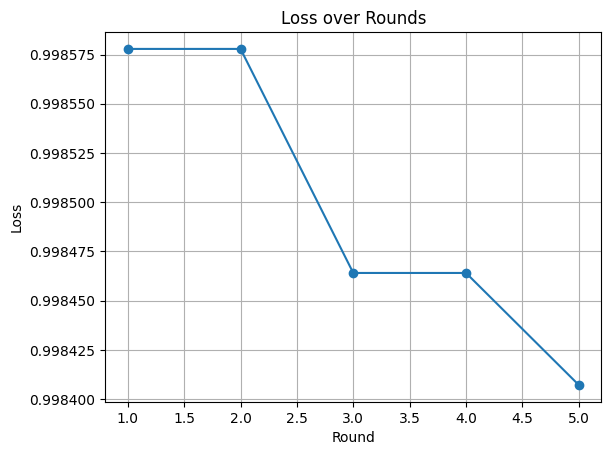

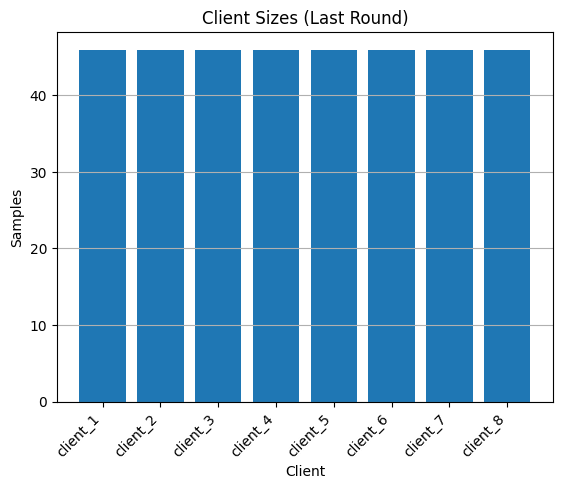

In [ ]:
plot_fl_report(report_fnn, show_loss=True, save_prefix="fl_demo")

In [ ]:
report = run_federated_round(
    global_model=lstm_bc,             # compiled LSTM model (expects input_shape=(52,1))
    X=X_test_lstm,                    # ignored when client_assignment is provided
    y=y_test,                         # ignored when client_assignment is provided
    model_kind="lstm",                # <-- important
    users=users,
    batch_size=128,
    local_epochs=1,
    rounds=5,
    verbose=1,
    log_params=True,
    show_parameter_numbers=True,
    values_per_layer=5,
    eval_data=(X_test_lstm, y_test),  # global eval after each round
)


[FL] Starting simulation: 5 rounds, 8 clients
[FL] Samples per client: {'client_1': 2198, 'client_2': 2198, 'client_3': 2198, 'client_4': 2197, 'client_5': 2197, 'client_6': 2197, 'client_7': 2197, 'client_8': 2197}
[FL] Trainable parameters: 3446

[FL] ----- Round 1/5 -----
[FL] Global eval -> loss: 0.9987, compile_metrics: 0.9990

[FL] ----- Round 2/5 -----
[FL] Global eval -> loss: 0.9987, compile_metrics: 0.9990

[FL] ----- Round 3/5 -----
[FL] Global eval -> loss: 0.9987, compile_metrics: 0.9990

[FL] ----- Round 4/5 -----
[FL] Global eval -> loss: 0.9987, compile_metrics: 0.9990

[FL] ----- Round 5/5 -----
[FL] Global eval -> loss: 0.9987, compile_metrics: 0.9990


In [ ]:
import tensorflow as tf

# Example: simple model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu", input_shape=(52,)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

# Train on dummy data
import numpy as np
X = np.random.rand(100, 52)
y = np.random.randint(0, 10, size=100)
model.fit(X, y, epochs=1)

# Save full model (preferred modern way)
model.save("my_model.keras")

# # Save only weights
# model.save_weights("my_model.weights.h5")

# # Restore later
# restored = tf.keras.models.load_model("my_model.keras")
# restored.load_weights("my_model.weights.h5")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4683  


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
